C:\Users\karla\AppData\Local\Temp\ipykernel_16572\142610892.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


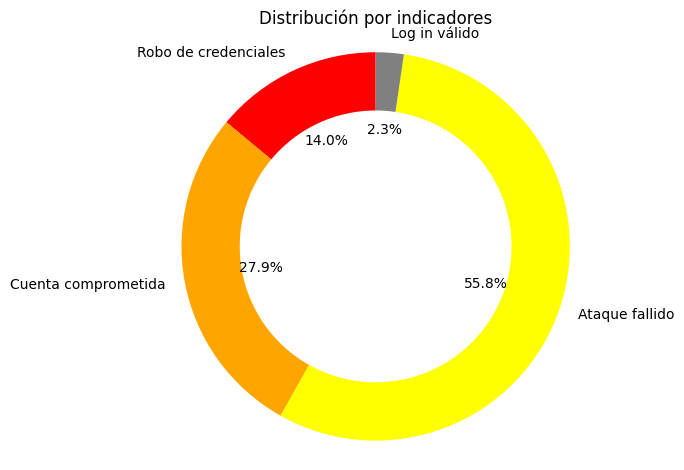

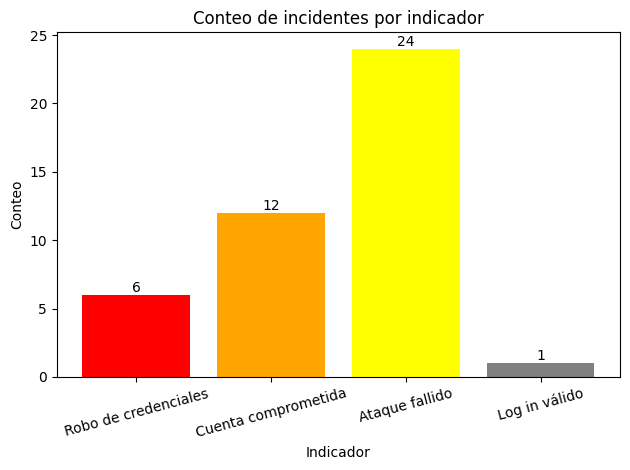

In [15]:
# pip install psycopg2-binary pandas matplotlib

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

try:
    conn = psycopg2.connect(
        dbname="desafiogrupo1",
        user="desafiogrupo1_user",
        password="g7jS0htW8QqiGPRymmJw0IJgb04QO3Jy",
        host="dpg-d36i177fte5s73bgaisg-a.oregon-postgres.render.com",
        port="5432",
        sslmode="require"
    )

    cur = conn.cursor()
    query = """
    SELECT *
    FROM public.logs
    WHERE indicators IN ('Robo de credenciales', 'Cuenta comprometida', 'Ataque fallido', 'Log in válido');
    """

    # Lee al DataFrame
    df = pd.read_sql(query, conn)

    # Agrupa: total de registros por indicador
    df_group = (
        df.groupby('indicators')['severity']
          .size()
          .reset_index(name='total')
    )

    # Mapa de colores
    color_map = {
        "Robo de credenciales": "red",
        "Cuenta comprometida": "orange",
        "Ataque fallido": "yellow",
        "Log in válido": "gray",
    }

    # Orden fijo para que los colores coincidan
    indicador_order = ["Robo de credenciales", "Cuenta comprometida", "Ataque fallido", "Log in válido"]
    df_group['indicators'] = pd.Categorical(df_group['indicators'], categories=indicador_order, ordered=True)
    df_group = df_group.sort_values('indicators').reset_index(drop=True)

    if df_group.empty:
        print("No hay datos para los indicadores seleccionados.")
    else:
        # Lista de colores alineada con df_group
        colors = [color_map.get(str(lbl), "#d3d3d3") for lbl in df_group['indicators']]

        # --- Pie / Donut ---
        fig = plt.figure()
        wedges, texts, autotexts = plt.pie(
            df_group['total'],
            labels=df_group['indicators'].astype(str),
            colors=colors,
            autopct='%1.1f%%',
            wedgeprops=dict(width=0.3),   # <- donut
            startangle=90,
            textprops={'color': 'black', 'fontsize': 10}
        )
        # Colorea los porcentajes dentro del donut
        for t in autotexts:
            t.set_color('black')
            t.set_fontsize(10)

        plt.axis('equal')
        plt.title('Distribución por indicadores', color='black')
        plt.tight_layout()
        plt.show()

        # ====== GRÁFICO DE BARRAS: conteo absoluto ======
        fig = plt.figure()
        x = range(len(df_group))
        plt.bar(x, df_group['total'], tick_label=df_group['indicators'].astype(str), color=colors)

        plt.title('Conteo de incidentes por indicador', color='black')
        plt.xlabel('Indicador', color='black')
        plt.ylabel('Conteo', color='black')
        plt.xticks(rotation=15)

        # Etiquetas con el conteo encima de cada barra
        for xi, yi in zip(x, df_group['total']):
            plt.text(xi, yi, str(yi), ha='center', va='bottom', fontsize=10, color='black')

        plt.tight_layout()
        plt.show()

finally:
    try:
        cur.close()
    except Exception:
        pass
    try:
        conn.close()
    except Exception:
        pass
